In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse

from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

## Extracting all the jet particles data from the monojet event Data
## and Storing it as pandas DataFrame with the required Column Headers.

In [2]:
## Creating a dataset from monojet files
data_path = "./monojet_Zp2000.0_DM_50.0_chan3.csv"
f = open(data_path)
lines = f.readlines() # Since this is a small file, we can store it in a memory
f.close()

In [3]:
data = []
for l in lines:
    line = l.split(";")
    for j in line:
        if j[0] == 'j':
            data.append([x for x in j[2:].split(",")])

In [4]:
column_values = ["E", "pt", "eta", "phi"]
df = pd.DataFrame(data = data,  columns = column_values)
df = df.astype(float)
df.head()

,E,pt,eta,phi
0,258722.0,243675.0,0.328962,2.25014
1,520092.0,108590.0,-2.247300,-1.85679
2,383024.0,88405.6,2.145160,-1.95635
3,39507.6,35365.1,0.470460,-1.16445
4,225430.0,26878.2,-2.816080,-2.25938


## Creating Our Custom Normalization Function
### Here,
### E -> (log(E) - min) / (max - min)
### pt -> (log(pt) - min) / (max - min)
### eta -> (eta - min) / ( max - min)
### phi -> (phi - min) / (max - min)

In [5]:
def custom_normalize(dataset):
    dataset["pt"] = np.log10(dataset["pt"])
    dataset["E"] = np.log10(dataset["E"])
#     dataset["eta"] = dataset["eta"] / 5
#     dataset["phi"] = dataset["phi"] / 3
    return dataset

normalized_dataset = custom_normalize(df)

norm = MinMaxScaler().fit(normalized_dataset)
normalized_dataset.loc[:, :] = norm.transform(normalized_dataset) # Standard normalization

normalized_dataset.head()

,E,pt,eta,phi
0,0.454361,0.527621,0.540265,0.858172
1,0.588669,0.349997,0.272551,0.204491
2,0.529828,0.304804,0.728996,0.188644
3,0.092886,0.103455,0.554969,0.314688
4,0.427866,0.043150,0.213446,0.140413


## Plotting the normalized Data

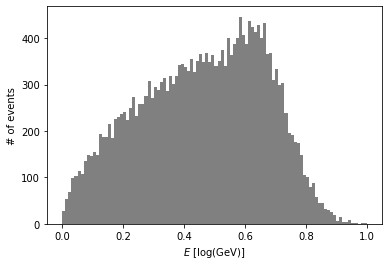

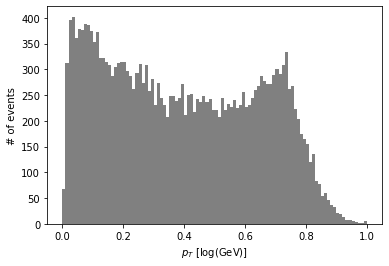

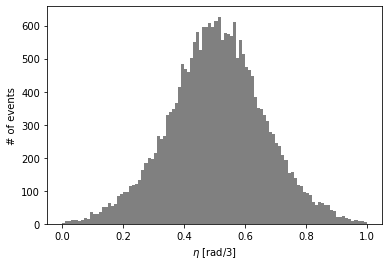

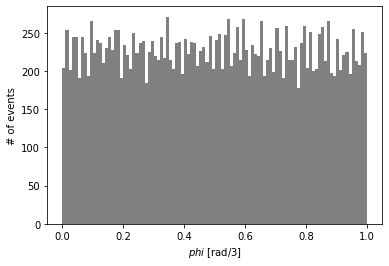

In [6]:
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]',  '[log(GeV)]', '[rad/3]', '[rad/3]' ]
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$phi$']

branches=["E","pt","eta","phi"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(normalized_dataset[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
#     plt.savefig("Nfourmomentum_"+branches[kk],dpi=300)
    plt.show()

In [7]:
## Splitting the dataset into training and test data

X_train, X_test = train_test_split(normalized_dataset, test_size=0.1, random_state=42)
train_x, test_x = train_test_split(X_train, test_size=0.15)

In [8]:
# train_x = X_train
train_y = train_x
# test_x = X_test# y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

In [9]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

## Auto Encoder Model
### Having 7 fully connected layers
### with 200, 200, 20, 3, 20, 200, 200 nodes
### with LeakyRelu as an activation function

In [10]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.LeakyReLU = nn.LeakyReLU()

    def encode(self, x):
        return self.en4(self.LeakyReLU(self.en3(self.LeakyReLU(self.en2(self.LeakyReLU(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.LeakyReLU(self.de3(self.LeakyReLU(self.de2(self.LeakyReLU(self.de1(self.LeakyReLU(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.01)
)

In [11]:

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

Learning rate with the minimum loss: 0.025118863582611083
Learning rate with the steepest gradient: 0.0014454397605732083


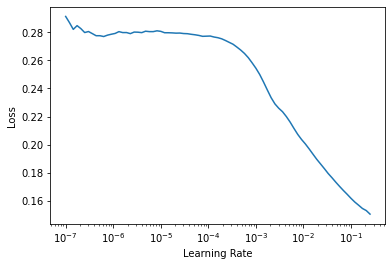

In [12]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [13]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(100,lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')
# learn.fit_one_cycle(100, lr_min)

[0, 0.06378556042909622, 0.0532674565911293, '00:00']
[0, 0.06378556042909622, 0.0532674565911293, '00:00']
[1, 0.05479815974831581, 0.05284058675169945, '00:00']
[1, 0.05479815974831581, 0.05284058675169945, '00:00']
[2, 0.05015411600470543, 0.03429381549358368, '00:00']
[2, 0.05015411600470543, 0.03429381549358368, '00:00']
[3, 0.029290439561009407, 0.011109274812042713, '00:00']
[3, 0.029290439561009407, 0.011109274812042713, '00:00']
[4, 0.014548487961292267, 0.008984490297734737, '00:00']
[4, 0.014548487961292267, 0.008984490297734737, '00:00']
[5, 0.010502303950488567, 0.008952353149652481, '00:00']
[5, 0.010502303950488567, 0.008952353149652481, '00:00']
[6, 0.009419931098818779, 0.008940150961279869, '00:00']
[6, 0.009419931098818779, 0.008940150961279869, '00:00']
[7, 0.009037942625582218, 0.008786623366177082, '00:00']
[7, 0.009037942625582218, 0.008786623366177082, '00:00']
[8, 0.008700337260961533, 0.008579774759709835, '00:00']
[8, 0.008700337260961533, 0.00857977475970983

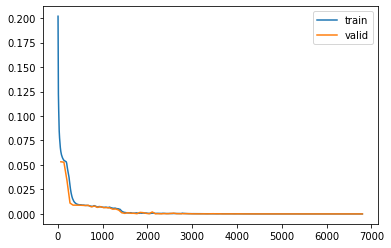

In [14]:
recorder.plot_loss()

In [15]:
def custom_unnormalize(dataset_df):
#     df['eta'] = df['eta'] * 5
#     df['phi'] = df['phi'] * 3
    norm.inverse_transform(dataset_df)
    dataset_df['E'] = 10**dataset_df['E']
#     df['m'] = 10**df['m']
    dataset_df['pt'] = 10**(dataset_df['pt'])
    return df

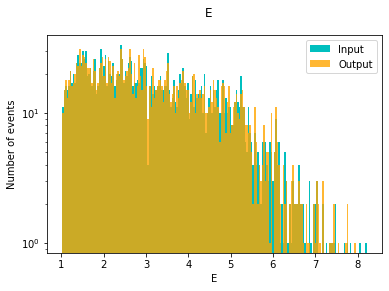

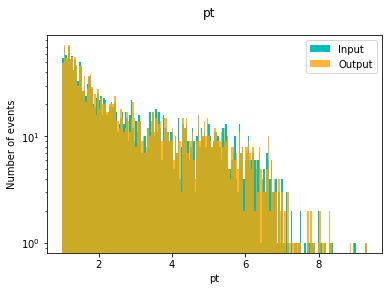

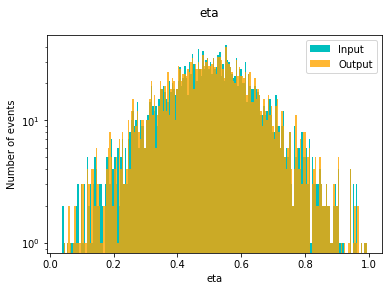

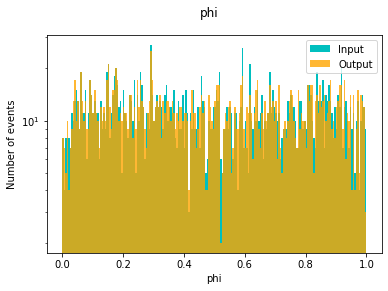

In [16]:

import numpy as np
import os

plt.close('all')
unit_list = ['[GeV]', '[GeV]', '[rad]', '[rad]']
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$phi$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')
save_dir = "./plotOutput"
save = True # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(X_test.values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=X_test.columns)
pred_df = pd.DataFrame(pred, columns=X_test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(X_test.columns[kk])
    plt.xlabel(X_test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,X_test.columns[kk]+'N.png'), dpi=300)
    plt.legend()

## Plotting the residual Plot to see the variance of predicted output from the input data

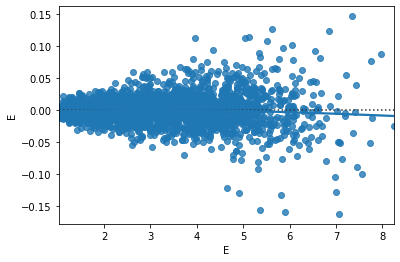

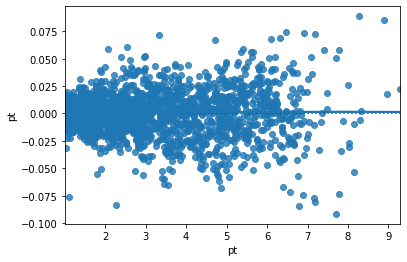

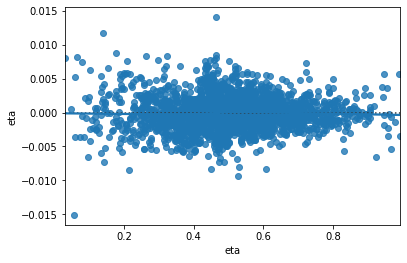

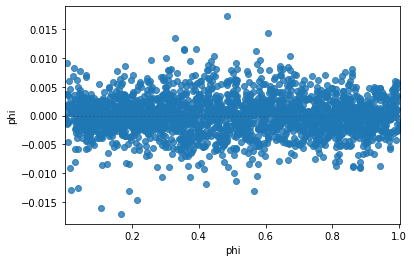

In [17]:
branches=["E","pt","eta","phi"]

for i in branches:
    sns.residplot(x=pred_df[i], y=data_df[i], lowess=True)
    plt.savefig(os.path.join(save_dir,i+'N_residual.png'), dpi=300)
    plt.show()

## An example showing the working of encoder and decoder separately

In [18]:
e_code = model.encode(torch.tensor([0.527866 ,0.043150 ,0.113446 ,0.190413]))

In [19]:
# Here we can see that our model actually reduce the dimension from 4-D to 3-D
e_code

tensor([ 0.3362,  0.9150, -4.7212], grad_fn=<AddBackward0>)

In [20]:
output = model.decode(e_code)

In [21]:
# And here it recreates the 4-D data from our encoded lower dimensional input
output

tensor([0.5835, 0.0229, 0.1215, 0.1918], grad_fn=<AddBackward0>)